# Fake News Detection

The following document details my data science project on Fake News Detection using Python. I have used a Term Frequency - Inverse Document Frequency Vectorizer along with a Passive Aggressive Classifier for this project. Additionally, I have submitted my final predictions on the test dataset on [kaggle.com](https://www.kaggle.com/c/fake-news) and received the **Final Score** of **95.256%**.

---

# Problem Statement

Fake News refers to news that may be hoaxes, generally spread through social media and other online media. The aim behind circulating fake news is to impose specific ideas or claims onto a large audience. It leads to a lack of trust in the media, which can cause significant ramifications in society. 

Thus, this represents a text classification problem where we must classify an article as "Real" or "Fake." I will apply classification techniques on a dataset of news articles with a frequency vectorizer. Later, I will test this model's accuracy and performance on unclassified articles. 

---

# Concepts Used

The Fake News Detection Model makes use of different machine learning concepts. Thus, I have attempted to summarise each technique used briefly. 

## Tf-Idf Vectorizer

The Term Frequency-Inverse Document Frequency Vectorizer helps us in converting our text strings to numerical representations. As seen from its name, the TfIdf Vectorizer consists of two parts:

**Term Frequency (Tf):** It counts how many times a particular word appears in a particular text file. For example, if we consider the word "the." It is a very common word and will appear with high frequency in almost every article; however, it does not add any extra information about what the article entails. Thus, we need to find a way to assign weightage to words that are important in the context of the articles. 

**Inverse Document Frequency (Idf):** We can solve the problem mentioned above through IDF. Here, we take the log of [the number of articles divided by the number of articles in which that word appears]. For words such as "the" (which appear in almost every document), the ratio will be close to 1. Therefore, the log of this ratio comes out to 0. 

**_Finally, to determine the weightage of a word, we multiply the Tf and the Idf._** 

## Passive Aggressive Classifier

This classifier follows passive-aggressive learning models for large scale learning. Here, **passive** signifies that if the classification is correct, we keep the model, while **aggressive** signifies that if the classification is incorrect, the model gets updated to adjust more of the misclassified records. Therefore, it updates to correct the loss. 

---

# Data

I am using a dataset from [kaggle.com](https://www.kaggle.com/c/fake-news/data?select=train.csv) which contains the following features:

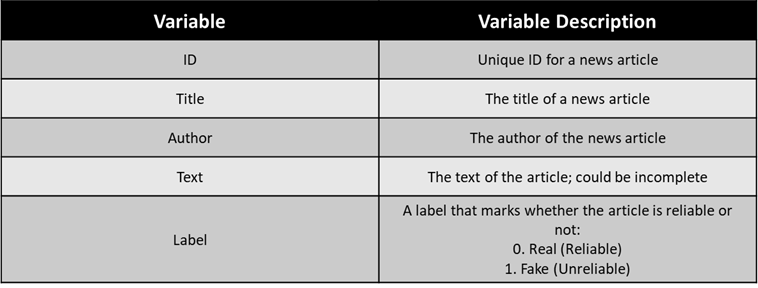

The entire dataframe has been divided into a training and testing dataset. Both the training and testing data contain identical attributes, with the exception of the "label" column in the testing data. The training data consists of 20,800 rows and 5 columns, whereas the testing data consists of 5,200 rows and 4 columns.

In [1]:
#Importing the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the training dataset
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
#Load the testing dataset
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(5200, 4)


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
#Calculating the train-test split
round(train.shape[0]/(train.shape[0] + test.shape[0]), 2), round(test.shape[0]/ (train.shape[0] + test.shape[0]), 2)

(0.8, 0.2)

In [5]:
#Features of both datasets
train.columns, test.columns

(Index(['id', 'title', 'author', 'text', 'label'], dtype='object'),
 Index(['id', 'title', 'author', 'text'], dtype='object'))

In [6]:
#Observe the data types 
train.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

In [7]:
#Creating copies of the training and testing dataset
train_original = train.copy()
test_original = test.copy()

In [8]:
train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [9]:
round(train['label'].value_counts(normalize=True), 2)

1    0.5
0    0.5
Name: label, dtype: float64

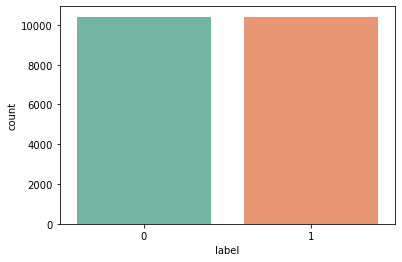

In [10]:
#Visualizing the number of fake and real articles
sns.countplot(x = 'label', data = train, palette="Set2")

We can see that the proportion of real and fake articles in the training dataset is roughly equal at 51% and 49% respectively. 

---

# Checking for null values and outliers

## Null Values

In [11]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

We can see that the "title" and "author" columns contain a lot of missing values, compared to "text." However, for our analysis, the text columns is of importance, as it is where our news articles are stored. We do not need an article to have the title and/ or author mentioned, to classify it as real or fake.

Thus,we drop those records where the "text" column is null.

In [12]:
train.dropna(axis = 0, how = "any", subset = ['text'], thresh = None, inplace = True)

Similarly for the test dataset:

In [13]:
test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [14]:
#We replace the na values in text with: ' '
test = test.fillna(' ')

## Outliers

To check the number of outliers in our dataset, we can check the number of characters in each article and identify the range and mean of this number. We will use len() for this task.

In [15]:
length = []
[length.append(len(str(text))) for text in train['text']]

#Creating a new column for the length of an article
train['length'] = length

In [16]:
#Showing the minimum, maximum, and average length
print("Minimum Length: ", min(train['length']), "\nMaximum Length: ", max(train['length']), "\nAverage Length: ", round(sum(train['length'])/len(train['length'])))

Minimum Length:  1 
Maximum Length:  142961 
Average Length:  4553


We see that some records contain only 1 character, which will not be of much use to us. Thus, we can set a minimum number of characters that we will need to validate a news article. 100 characters roughly constitute 20-30 words, thus, we set the minimum number of characters to be 100.

In [17]:
#Checking to see how many records exist with less than 100 characters
len(train[train['length'] < 100])

404

In [18]:
#Checking what the short texts look like
print(train['text'][train['length'] < 100])

82                                                        
169                                                       
173                                        Guest   Guest  
196                 They got the heater turned up on high.
295                                                       
                               ...                        
20431         \nOctober 28, 2016 The Mothers by stclair by
20513                                                     
20636                                   Trump all the way!
20764    Chart Of The Day: Restaurant Performance Index...
20769    source Add To The Conversation Using Facebook ...
Name: text, Length: 404, dtype: object


We notice many articles are simply blank (with ' ', which is why they were not counted as null), and many others are just random sentences. Such articles amount to 404 out of our total count. We can remove these articles and then check the length statistics again.

In [19]:
train = train.drop(train['text'][train['length'] < 100].index, axis = 0)

In [20]:
#Showing the minimum, maximum, and average length
print("Minimum Length: ", min(train['length']), "\nMaximum Length: ", max(train['length']), "\nAverage Length: ", round(sum(train['length'])/len(train['length'])))

Minimum Length:  100 
Maximum Length:  142961 
Average Length:  4642


---

# Model Building

To create our model, we will first have to exclude the "label" variable and store it in a different dataset. We will create another dataset with all attributes apart from "label."

In [21]:
#Independent Variables
X = train['text']

#Dependent Variable
Y = train['label']

Now we will divide the training dataset into two parts: training and validation. This technique, known as Cross Validation, involves reserving a particular sample of a dataset on which we do not train the model. Later, we test the model before finalizing it. 

We will divide the training dataset with a 80:20 ratio, where 80% of our data is the training data, and 20% of our data is the validation set.

In [22]:
xtr, xvl, ytr, yvl = train_test_split(X, Y, test_size = 0.2, random_state = 101)

In [23]:
#Initializing a Term Frequency - Inverse Document Frequency Vectorizer
TfIdf = TfidfVectorizer(stop_words='english', max_df=0.7)

#Fit and transform training set 
TfIdf_train = TfIdf.fit_transform(xtr)
TfIdf_val = TfIdf.transform(xvl)

#Setting up Passive Aggressive Classifier
PAC=PassiveAggressiveClassifier(max_iter=50)
PAC.fit(TfIdf_train,ytr)

#Predicting on the test set
pred_values = PAC.predict(TfIdf_val)
score = accuracy_score(yvl, pred_values)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 96.41%


We have gotten an accuracy of 96%. Next, we print the classification report and the confusion matrix.

Text(33.0, 0.5, 'True')

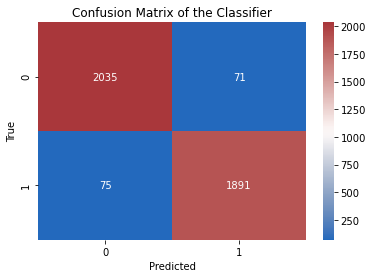

In [24]:
conf_matrix = confusion_matrix(yvl, pred_values)
sns.heatmap(conf_matrix, annot = True, cmap = 'vlag', fmt = 'd')
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')

---

# Conclusion

From our above code, we can see that we correctly identified 2035 articles as REAL (reliable) and 1891 articles as FAKE (unreliable). 

---

# Submission on Kaggle

In [25]:
TfIdf_test_final = TfIdf.transform(test['text'])
pred_values_test = PAC.predict(TfIdf_test_final)

In [26]:
submission = pd.read_csv('submit.csv')
submission['label'] = pred_values_test

In [27]:
print(submission.shape)
submission.head()

(5200, 2)


,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [29]:
submission.to_csv('finalsubmission.csv', index = False)

For the final submission I have received the **Final Score** of **95.256%** on the Leaderboard.